In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

from dustmaps.sfd import SFDQuery
from dustmaps.config import config
config['data_dir'] = '/home/ana/data/dust'

import pickle

coord.galactocentric_frame_defaults.set('v4.0')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [2]:
plt.style.use('notebook')

In [3]:
def deredden_sfd(t):
    """Deredden using SFD dust map"""
    # load SFD reader
    sfd = SFDQuery()
    
    # Gaia extinction coefficients from Babusiaux+2018
    kg = np.array([0.9761, -0.1704, 0.0086, 0.0011, -0.0438, 0.0013, 0.0099])
    kbp = np.array([1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043])
    krp = np.array([0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006])
    
    # query dust map
    c = coord.SkyCoord(ra=t['ra'], dec=t['dec'], frame='icrs')
    ebv = sfd(c)
    a0 = 3.1*ebv
    
    # solving for (BP_RP)_0
    # cubic equation (hence 4 elements in p)
    N = len(t)
    p = np.zeros((4,N))
    bp_rp = np.zeros(N)
    
    p[0] = a0 * (krp[3] - kbp[3])
    p[1] = a0 * (krp[2] - kbp[2])
    p[2] = a0 * (krp[1] - kbp[1]) + a0**2 * (krp[6] - kbp[6]) - 1
    p[3] = a0 * (krp[0] - kbp[0]) + a0**2 * (krp[4] - kbp[4]) + a0**3 * (krp[5] - kbp[5]) + t['bp_rp']
    
    for i in range(N):
        r = np.roots(p[:,i])
        ind = np.argmin(np.abs(r - t['bp_rp'][i]))
        bp_rp[i] = r[ind]
    
    ag = (kg[0] + kg[1]*bp_rp + kg[2]*bp_rp**2 + kg[3]*bp_rp**3 + kg[4]*a0 + kg[5]*a0**2 + kg[6]*bp_rp*a0) * a0
    g = t['phot_g_mean_mag'] - ag
    
    t['bp_rp0'] = bp_rp
    t['g0'] = g

def deredden_gaia(t):
    """Use DR3 GSPhot derived extinctions to deredden"""
    
    t['bp_rp0'] = t['bp_rp'] - t['ebpminrp_gspphot']
    t['g0'] = t['phot_g_mean_mag'] - t['ag_gspphot']

In [4]:
for i in range(4):
    t = Table.read('../data/gdr3_ylgr.{:d}.vot.gz'.format(i))
    ind = np.isfinite(t['bp_rp']) & np.isfinite(t['phot_g_mean_mag'])
    t = t[ind]
    deredden_sfd(t)
    
    if i==0:
        tout = t
    else:
        tout = vstack([tout, t])


/tmp/ipykernel_14581/2803234286.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  bp_rp[i] = r[ind]


In [5]:
len(tout)

2665073

In [6]:
# magnitude uncertainties

#zeropoint uncertainties
sigma_g0, sigma_bp0, sigma_rp0 = 0.0028, 0.0028, 0.0028

g_err = np.sqrt(sigma_g0**2 + (2.512/(np.log(10.)*tout['phot_g_mean_flux_over_error']))**2)
bp_err = np.sqrt(sigma_bp0**2 + (2.512/(np.log(10.)*tout['phot_bp_mean_flux_over_error']))**2)
rp_err = np.sqrt(sigma_rp0**2 + (2.512/(np.log(10.)*tout['phot_rp_mean_flux_over_error']))**2)
bprp_err = np.sqrt(bp_err**2 + rp_err**2)

In [7]:
tout['g_err'] = g_err
tout['bp_rp_err'] = bprp_err

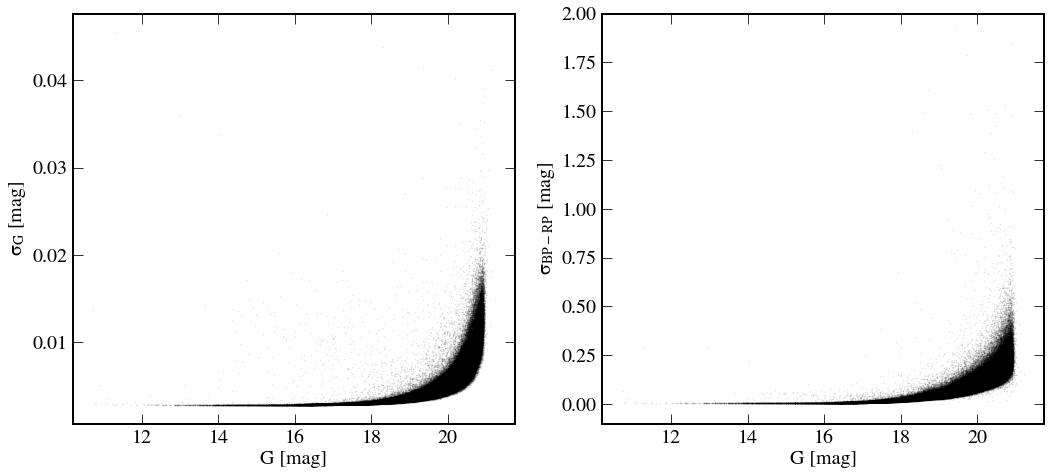

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
plt.sca(ax[0])
plt.plot(tout['phot_g_mean_mag'][::10], g_err[::10], 'k.', ms=1, alpha=0.1)

plt.xlabel('G [mag]')
plt.ylabel('$\sigma_G$ [mag]')

plt.sca(ax[1])
plt.plot(tout['phot_g_mean_mag'][::10], bprp_err[::10], 'k.', ms=1, alpha=0.1)

plt.ylim(-0.1,2)
plt.xlabel('G [mag]')
plt.ylabel('$\sigma_{BP-RP}$ [mag]')

plt.tight_layout()

In [9]:
tout.write('../data/ylgr_combined_sfd.fits.gz', overwrite=True)